<a href="https://colab.research.google.com/github/Yuheon/Sharp-Aware-Minimization/blob/main/Fashion_MNIST_SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn

In [ ]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])

# download training data, test data
train_dataset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
test_dataset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)

/home/yuheon/anaconda3/envs/codingtest/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
batch_size = 64

# load training set, test set 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:


class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
        )
        
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.3)
        )
        
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        

    def forward(self, x):
        x= self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)
        x = self.layer4(x)
        x = self.fc2(x)
        
        return x

In [ ]:

class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups
    
    
    # epsilon hat, p = 2
    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12) # prevent / 0

            for p in group["params"]:
                if p.grad is None: continue
                e_w = p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"
                self.state[p]["e_w"] = e_w

        if zero_grad: self.zero_grad()

    # update weight : wt+1 = wt - eta * g
    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.sub_(self.state[p]["e_w"])  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()


    # caculate 2 norm of gradient Ls(w)
    def _grad_norm(self): 
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        (1.0 * p.grad).norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
epochs = 100
learning_rate = 0.001

In [ ]:
model_with_SGD = CNN().to(device)
optimizer_SGD = torch.optim.SGD(model_with_SGD.parameters(), lr=learning_rate, momentum=0.9)


criterion = nn.CrossEntropyLoss()

# sgd_train_loss = []
sgd_train_acc = []

# sgd_test_loss = []
sgd_test_acc = []

for epoch in range(epochs):
    model_with_SGD.train()
    
    total_loss = 0
    correct = 0
    
    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)
        
        optimizer_SGD.zero_grad()
        hypothesis = model_with_SGD(X)
        loss = criterion(hypothesis, Y)
        loss.backward()
        optimizer_SGD.step()
        
        # total_loss += loss.item()
        predicted = torch.argmax(hypothesis, 1)
        
        correct += (predicted == Y).sum().item()

    # sgd_train_loss.append(total_loss / len(train_loader.dataset))     
    sgd_train_acc.append(100. * correct / len(train_loader.dataset))        
        
    
    
    # total_loss = 0
    correct = 0
    
    with torch.no_grad():
        model_with_SGD.eval()
        for X, Y in test_loader:
            X = X.to(device)
            Y = Y.to(device)
        
            hypothesis = model_with_SGD(X)
            
            # total_loss += loss.item()
            predicted = torch.argmax(hypothesis, 1)
            correct += (predicted == Y).sum().item()
            
            
    # sgd_test_loss.append(total_loss / len(test_loader.dataset))
    sgd_test_acc.append(100. * correct / len(test_loader.dataset))         
            
    
    print('Epoch : {}, Training Accuracy : {:.2f}%,  Test Accuracy : {:.2f}% \n'.format(
        epoch+1, sgd_train_acc[-1], sgd_test_acc[-1]))
            
        

Epoch : 1, Training Accuracy : 56.10%,  Test Accuracy : 75.51% 

Epoch : 2, Training Accuracy : 77.13%,  Test Accuracy : 79.89% 

Epoch : 3, Training Accuracy : 80.59%,  Test Accuracy : 81.91% 

Epoch : 4, Training Accuracy : 82.81%,  Test Accuracy : 83.53% 

Epoch : 5, Training Accuracy : 84.46%,  Test Accuracy : 84.97% 

Epoch : 6, Training Accuracy : 85.52%,  Test Accuracy : 86.09% 

Epoch : 7, Training Accuracy : 86.36%,  Test Accuracy : 86.31% 

Epoch : 8, Training Accuracy : 87.08%,  Test Accuracy : 87.17% 

Epoch : 9, Training Accuracy : 87.58%,  Test Accuracy : 87.20% 

Epoch : 10, Training Accuracy : 87.92%,  Test Accuracy : 87.75% 

Epoch : 11, Training Accuracy : 88.27%,  Test Accuracy : 88.13% 

Epoch : 12, Training Accuracy : 88.72%,  Test Accuracy : 88.03% 

Epoch : 13, Training Accuracy : 88.86%,  Test Accuracy : 88.53% 

Epoch : 14, Training Accuracy : 89.22%,  Test Accuracy : 88.48% 

Epoch : 15, Training Accuracy : 89.37%,  Test Accuracy : 88.75% 

Epoch : 16, Trainin

In [ ]:


model_with_SAM = CNN().to(device)

base_optimizer = torch.optim.SGD  # define an optimizer for the "sharpness-aware" update
optimizer_SAM = SAM(model_with_SAM.parameters(), base_optimizer, lr=learning_rate, momentum=0.9)


criterion = nn.CrossEntropyLoss()

# sam_train_loss = []
sam_train_acc = []

# sam_test_loss = []
sam_test_acc = []


for epoch in range(epochs):
    
    model_with_SAM.train()
    correct = 0
    
    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)
        
        # first forward-backward pass
        
        hypothesis = model_with_SAM(X)
        
        loss = criterion(hypothesis, Y)  # use this loss for any training statistics
        loss.backward()
        optimizer_SAM.first_step(zero_grad=True)

        # second forward-backward pass
        
        criterion(model_with_SAM(X), Y).backward()  # make sure to do a full forward pass
        optimizer_SAM.second_step(zero_grad=True)
        
        predicted = torch.argmax(hypothesis, 1)
        correct += (predicted == Y).sum().item()
        
    sam_train_acc.append(100. * correct / len(train_loader.dataset))
    
    
    
    correct = 0
    with torch.no_grad():
        
        model_with_SAM.eval()
        
        for X, Y in test_loader:
            X = X.to(device)
            Y = Y.to(device)
            
            hypothesis = model_with_SAM(X)
            predicted = torch.argmax(hypothesis, 1)
            correct += (predicted == Y).sum().item()
    
    sam_test_acc.append(100. * correct / len(test_loader.dataset))

    
    
    print('Epoch : {}, Training Accuracy : {:.2f}%,  Test Accuracy : {:.2f}% \n'.format(
        epoch+1, sam_train_acc[-1], sam_test_acc[-1]))
        
        


Epoch : 1, Training Accuracy : 54.67%,  Test Accuracy : 70.77% 

Epoch : 2, Training Accuracy : 76.08%,  Test Accuracy : 77.89% 

Epoch : 3, Training Accuracy : 80.12%,  Test Accuracy : 81.55% 

Epoch : 4, Training Accuracy : 82.61%,  Test Accuracy : 83.20% 

Epoch : 5, Training Accuracy : 84.34%,  Test Accuracy : 84.49% 

Epoch : 6, Training Accuracy : 85.42%,  Test Accuracy : 85.36% 

Epoch : 7, Training Accuracy : 86.08%,  Test Accuracy : 85.87% 

Epoch : 8, Training Accuracy : 86.86%,  Test Accuracy : 86.52% 

Epoch : 9, Training Accuracy : 87.38%,  Test Accuracy : 86.88% 

Epoch : 10, Training Accuracy : 87.73%,  Test Accuracy : 87.27% 

Epoch : 11, Training Accuracy : 88.25%,  Test Accuracy : 87.59% 

Epoch : 12, Training Accuracy : 88.65%,  Test Accuracy : 87.83% 

Epoch : 13, Training Accuracy : 88.84%,  Test Accuracy : 88.27% 

Epoch : 14, Training Accuracy : 89.28%,  Test Accuracy : 88.33% 

Epoch : 15, Training Accuracy : 89.42%,  Test Accuracy : 88.73% 

Epoch : 16, Trainin

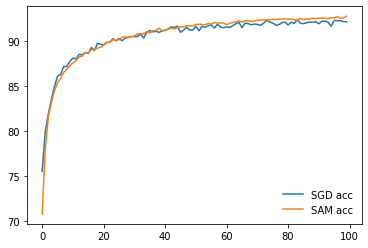

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(sgd_test_acc, label='SGD acc')
plt.plot(sam_test_acc, label='SAM acc')
plt.legend(frameon=False)

In [ ]:
model_with_SGD2 = CNN().to(device)
optimizer_SGD2 = torch.optim.SGD(model_with_SGD2.parameters(), lr=learning_rate, momentum=0.9)


criterion = nn.CrossEntropyLoss()

# sgd_train_loss = []
sgd_train_acc2 = []

# sgd_test_loss = []
sgd_test_acc2 = []

for epoch in range(epochs*2):
    model_with_SGD2.train()
    
    total_loss = 0
    correct = 0
    
    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)
        
        optimizer_SGD2.zero_grad()
        hypothesis = model_with_SGD2(X)
        loss = criterion(hypothesis, Y)
        loss.backward()
        optimizer_SGD2.step()
        
        # total_loss += loss.item()
        predicted = torch.argmax(hypothesis, 1)
        
        correct += (predicted == Y).sum().item()

    # sgd_train_loss.append(total_loss / len(train_loader.dataset))     
    sgd_train_acc2.append(100. * correct / len(train_loader.dataset))        
        
    
    
    # total_loss = 0
    correct = 0
    
    with torch.no_grad():
        model_with_SGD2.eval()
        for X, Y in test_loader:
            X = X.to(device)
            Y = Y.to(device)
        
            hypothesis = model_with_SGD2(X)
            
            # total_loss += loss.item()
            predicted = torch.argmax(hypothesis, 1)
            correct += (predicted == Y).sum().item()
            
            
    # sgd_test_loss.append(total_loss / len(test_loader.dataset))
    sgd_test_acc2.append(100. * correct / len(test_loader.dataset))         
            
    
    print('Epoch : {}, Training Accuracy : {:.2f}%,  Test Accuracy : {:.2f}% \n'.format(
        epoch+1, sgd_train_acc2[-1], sgd_test_acc2[-1]))
            
        

Epoch : 1, Training Accuracy : 56.73%,  Test Accuracy : 73.68% 

Epoch : 2, Training Accuracy : 76.98%,  Test Accuracy : 79.01% 

Epoch : 3, Training Accuracy : 80.33%,  Test Accuracy : 80.65% 

Epoch : 4, Training Accuracy : 82.45%,  Test Accuracy : 83.46% 

Epoch : 5, Training Accuracy : 84.06%,  Test Accuracy : 85.08% 

Epoch : 6, Training Accuracy : 85.18%,  Test Accuracy : 84.81% 

Epoch : 7, Training Accuracy : 86.11%,  Test Accuracy : 85.85% 

Epoch : 8, Training Accuracy : 86.93%,  Test Accuracy : 86.27% 

Epoch : 9, Training Accuracy : 87.53%,  Test Accuracy : 87.47% 

Epoch : 10, Training Accuracy : 87.94%,  Test Accuracy : 87.57% 

Epoch : 11, Training Accuracy : 88.39%,  Test Accuracy : 87.84% 

Epoch : 12, Training Accuracy : 88.76%,  Test Accuracy : 88.38% 

Epoch : 13, Training Accuracy : 89.10%,  Test Accuracy : 88.65% 

Epoch : 14, Training Accuracy : 89.40%,  Test Accuracy : 88.69% 

Epoch : 15, Training Accuracy : 89.60%,  Test Accuracy : 88.80% 

Epoch : 16, Trainin

Epoch : 125, Training Accuracy : 99.16%,  Test Accuracy : 92.17% 

Epoch : 126, Training Accuracy : 99.22%,  Test Accuracy : 92.25% 

Epoch : 127, Training Accuracy : 99.12%,  Test Accuracy : 91.96% 

Epoch : 128, Training Accuracy : 99.16%,  Test Accuracy : 92.25% 

Epoch : 129, Training Accuracy : 99.20%,  Test Accuracy : 92.28% 

Epoch : 130, Training Accuracy : 99.25%,  Test Accuracy : 92.51% 

Epoch : 131, Training Accuracy : 99.27%,  Test Accuracy : 92.25% 

Epoch : 132, Training Accuracy : 99.36%,  Test Accuracy : 92.50% 

Epoch : 133, Training Accuracy : 99.31%,  Test Accuracy : 92.35% 

Epoch : 134, Training Accuracy : 99.30%,  Test Accuracy : 92.44% 

Epoch : 135, Training Accuracy : 99.36%,  Test Accuracy : 92.38% 

Epoch : 136, Training Accuracy : 99.36%,  Test Accuracy : 92.33% 

Epoch : 137, Training Accuracy : 99.40%,  Test Accuracy : 92.42% 

Epoch : 138, Training Accuracy : 99.43%,  Test Accuracy : 92.35% 

Epoch : 139, Training Accuracy : 99.36%,  Test Accuracy : 92.2

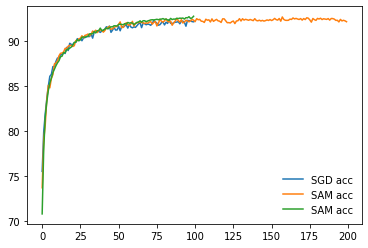

In [ ]:

plt.plot(sgd_test_acc, label='SGD acc')
plt.plot(sgd_test_acc2, label='SAM acc')
plt.plot(sam_test_acc, label='SAM acc')
plt.legend(frameon=False)

In [ ]:


model_with_SAM2 = CNN().to(device)

base_optimizer2 = torch.optim.SGD  # define an optimizer for the "sharpness-aware" update
optimizer_SAM2 = SAM(model_with_SAM2.parameters(), base_optimizer, lr=learning_rate, momentum=0.9)


criterion = nn.CrossEntropyLoss()

# sam_train_loss2 = []
sam_train_acc2 = []

# sam_test_loss2 = []
sam_test_acc2 = []


for epoch in range(epochs*2):
    
    model_with_SAM2.train()
    correct = 0
    
    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)
        
        # first forward-backward pass
        hypothesis = model_with_SAM2(X)
        
        loss = criterion(hypothesis, Y)  # use this loss for any training statistics
        loss.backward()
        optimizer_SAM2.first_step(zero_grad=True)

        # second forward-backward pass
        
        criterion(model_with_SAM2(X), Y).backward()  # make sure to do a full forward pass
        optimizer_SAM2.second_step(zero_grad=True)
        
        predicted = torch.argmax(hypothesis, 1)
        correct += (predicted == Y).sum().item()
        
    sam_train_acc2.append(100. * correct / len(train_loader.dataset))
    
    
    
    correct = 0
    with torch.no_grad():
        
        model_with_SAM2.eval()
        
        for X, Y in test_loader:
            X = X.to(device)
            Y = Y.to(device)
            
            hypothesis = model_with_SAM2(X)
            predicted = torch.argmax(hypothesis, 1)
            correct += (predicted == Y).sum().item()
    
    sam_test_acc2.append(100. * correct / len(test_loader.dataset))

    
    
    print('Epoch : {}, Training Accuracy : {:.2f}%,  Test Accuracy : {:.2f}% \n'.format(
        epoch+1, sam_train_acc2[-1], sam_test_acc2[-1]))
        
        


Epoch : 1, Training Accuracy : 52.61%,  Test Accuracy : 71.65% 

Epoch : 2, Training Accuracy : 75.27%,  Test Accuracy : 77.26% 

Epoch : 3, Training Accuracy : 79.26%,  Test Accuracy : 79.95% 

Epoch : 4, Training Accuracy : 81.79%,  Test Accuracy : 81.92% 

Epoch : 5, Training Accuracy : 83.57%,  Test Accuracy : 83.84% 

Epoch : 6, Training Accuracy : 84.98%,  Test Accuracy : 84.40% 

Epoch : 7, Training Accuracy : 85.84%,  Test Accuracy : 85.63% 

Epoch : 8, Training Accuracy : 86.61%,  Test Accuracy : 86.07% 

Epoch : 9, Training Accuracy : 87.13%,  Test Accuracy : 86.51% 

Epoch : 10, Training Accuracy : 87.59%,  Test Accuracy : 86.84% 

Epoch : 11, Training Accuracy : 87.99%,  Test Accuracy : 87.11% 

Epoch : 12, Training Accuracy : 88.40%,  Test Accuracy : 87.65% 

Epoch : 13, Training Accuracy : 88.85%,  Test Accuracy : 87.99% 

Epoch : 14, Training Accuracy : 89.10%,  Test Accuracy : 88.27% 

Epoch : 15, Training Accuracy : 89.41%,  Test Accuracy : 88.34% 

Epoch : 16, Trainin

Epoch : 125, Training Accuracy : 98.72%,  Test Accuracy : 92.97% 

Epoch : 126, Training Accuracy : 98.71%,  Test Accuracy : 93.02% 

Epoch : 127, Training Accuracy : 98.76%,  Test Accuracy : 93.04% 

Epoch : 128, Training Accuracy : 98.82%,  Test Accuracy : 92.92% 

Epoch : 129, Training Accuracy : 98.89%,  Test Accuracy : 93.05% 

Epoch : 130, Training Accuracy : 98.89%,  Test Accuracy : 92.84% 

Epoch : 131, Training Accuracy : 98.96%,  Test Accuracy : 93.07% 

Epoch : 132, Training Accuracy : 98.98%,  Test Accuracy : 92.99% 

Epoch : 133, Training Accuracy : 98.99%,  Test Accuracy : 92.94% 

Epoch : 134, Training Accuracy : 99.02%,  Test Accuracy : 92.90% 

Epoch : 135, Training Accuracy : 98.99%,  Test Accuracy : 93.00% 

Epoch : 136, Training Accuracy : 99.08%,  Test Accuracy : 92.74% 

Epoch : 137, Training Accuracy : 99.09%,  Test Accuracy : 92.95% 

Epoch : 138, Training Accuracy : 99.16%,  Test Accuracy : 92.97% 

Epoch : 139, Training Accuracy : 99.16%,  Test Accuracy : 92.9

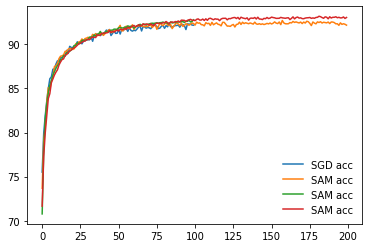

In [ ]:

plt.plot(sgd_test_acc, label='SGD acc')
plt.plot(sgd_test_acc2, label='SAM acc')
plt.plot(sam_test_acc, label='SAM acc')
plt.plot(sam_test_acc2, label='SAM acc')
plt.legend(frameon=False)